# Local differences in chlamydia prevalence, proportion diagnosed and positivity

In this example, we use local numbers of chlamydia tests and diagnoses recorded during 2012 to investigate local differences in incidence, prevalence and screening in men and women.


In [1]:
# This script also contains the functions linking observed tests, symptomatic/asymptomatic/toal diagnoses, 
# incidence, prevalence, screening and other model parameters
# Running it takes a little while because of all the symbolic algebra
%run -i test_diag_fun.py

# This script provides a function for calculating the likelihood of categorical data.
%run -i multinomial_pmf.py

# This script samples model parameters from prior distributions, following the method in england.ipynb.
%run -i sample_parameters.py

Surveillance data on chlamydia testing and diagnosis rates by English local authority (LA) in 2012 were downloaded from: http://www.chlamydiascreening.nhs.uk/ps/data.asp (downloaded 9 February 2016). Numbers of tests and diagnoses were copied into the csv file included with this notebook.

In [2]:
# now read in the local testing and diagnosis rates
import pandas as pd
from pandas import *
pd.options.mode.chained_assignment = None  # default='warn'

alldata = pd.read_csv('2012_age_sex_LA.csv')
alldata = alldata[alldata.la != 'Isles of Scilly'] # remove Scilly Isles because of small numbers
alldata.index = range(len(alldata))
print alldata[['la','tests.male.15-19','positives.male.15-19', 'population.male.15-19']][:10]

# la: Local Authority (Upper Tier)
# gor: Government Office Region
# phec: Public Health England Region
# pher: Public Health England Centre

                     la  tests.male.15-19  positives.male.15-19  \
0  Barking and Dagenham              1741                    83   
1                Barnet               491                    46   
2                Bexley               631                    55   
3                 Brent              1209                    98   
4               Bromley              1049                    59   
5                Camden              1225                    91   
6        City of London                12                     0   
7               Croydon              1570                   146   
8                Ealing              1126                    47   
9               Enfield               609                    44   

   population.male.15-19  
0                   6672  
1                  10694  
2                   7850  
3                   9809  
4                   9289  
5                   5915  
6                    113  
7                  12161  
8                  

Tests, diagnoses and population sizs for men aged 15-19 in ten LAs are printed above, to provide examples of the data used.

## Testing and diagnosis rates

Samples for the testing and diagnosis rates for 16-24-year-old men and women in each LA were generated from gamma distributions based on the data.

In [3]:
# NB random state (rs) is set in sample_parameters.py, above.

# set up arrays to store, for each LA: 
test_sample_m = empty([n_sample, len(alldata)]) # testing rate
test_sample_f = empty([n_sample, len(alldata)])
diag_sample_m = empty([n_sample, len(alldata)]) # observed diagnosis rate
diag_sample_f = empty([n_sample, len(alldata)])
diag_m_la = empty([n_sample, len(alldata)]) # predicted diagnosis rate
diag_f_la = empty([n_sample, len(alldata)])

for i in xrange(len(alldata.index)):
    
    #####
    # men
    #####
    # sample for the testing rate, per sexually active 15-24-year-old
    test_sample_m[:,i] = rs.gamma(alldata['tests.male.total'][i],1,size = n_sample)/ \
        rs.binomial(alldata['population.male.15-19'][i] + alldata['population.male.20-24'][i], 
                        p_active_m_16_24, size=n_sample)
    diag_sample_m[:,i] = rs.gamma(alldata['positives.male.total'][i],1,size = n_sample)/ \
        rs.binomial(alldata['population.male.15-19'][i] + alldata['population.male.20-24'][i], 
                        p_active_m_16_24, size=n_sample)
        
    #####
    # women
    #####
    # sample for the testing rate, per sexually active 15-24-year-old
    test_sample_f[:,i] = rs.gamma(alldata['tests.female.total'][i],1,size = n_sample)/ \
        rs.binomial(alldata['population.female.15-19'][i] + alldata['population.female.20-24'][i], 
                        p_active_f_16_24, size=n_sample)
    diag_sample_f[:,i] = rs.gamma(alldata['positives.female.total'][i],1,size = n_sample)/ \
        rs.binomial(alldata['population.female.15-19'][i] + alldata['population.female.20-24'][i], 
                        p_active_f_16_24, size=n_sample)



We now examine the correlation between local proportions tested and diagnosed, for men and women separately.

(0, 0.1)

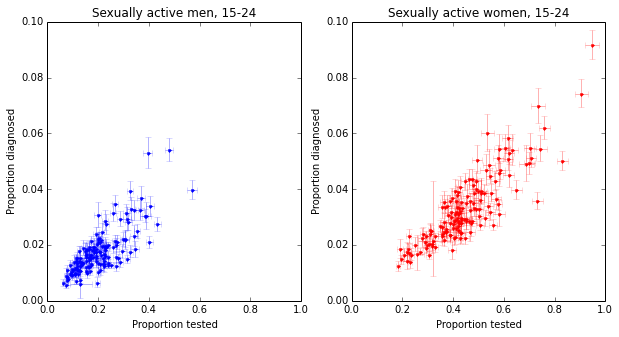

In [4]:
# Figure 1:
# plot testing and diagnosis rates to examine correlation
import matplotlib.pyplot as plt
%matplotlib inline

def plt_ppc(ax, xsample, ysample, index, ci, col, alpha=1): 
    # ci is the confidence interval required, as a %
    ax.errorbar(percentile(xsample, 50, index), 
                percentile(ysample, 50, index), 
                xerr=squeeze(
                    array([[percentile(xsample,50, index) - percentile(xsample, (100.-ci)/2, index)], 
                           [percentile(xsample, (100.+ci)/2, index) - percentile(xsample,50, index)]])
            ), 
                yerr=squeeze(
                    array([[percentile(ysample,50, index) - percentile(ysample, (100.-ci)/2, index)], 
                           [percentile(ysample, (100.+ci)/2, index) - percentile(ysample,50, index)]])
            ),
                linestyle = 'None', color = col, alpha=alpha)

fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

plt_ppc(ax1, test_sample_m, diag_sample_m, 0, 95, 'b', alpha=0.3)
ax1.plot(percentile(test_sample_m, 50, 0), percentile(diag_sample_m, 50, 0), '.b')
plt_ppc(ax2, test_sample_f, diag_sample_f, 0, 95, 'r', alpha=0.3)
ax2.plot(percentile(test_sample_f, 50, 0), percentile(diag_sample_f, 50, 0), '.r')

ax1.set_title('Sexually active men, 15-24'); ax2.set_title('Sexually active women, 15-24')

ax1.set_xlabel('Proportion tested'); ax2.set_xlabel('Proportion tested')
ax1.set_ylabel('Proportion diagnosed'); ax2.set_ylabel('Proportion diagnosed')

ax1.set_xlim([0,1]); ax2.set_xlim([0,1])
ax1.set_ylim([0,0.1]); ax2.set_ylim([0,0.1])

Plotting the proportion of the sexually active population tested for chlamydia against the proportion diagnosed shows clearly the correlation between the two: as more tests are conducted, more infections are discovered. In these (and all subsequent) plots, markers show the median of the sampled distributions, and error bars the 2.5th and 97.5th centiles.

## Positivity and prevalence

Using the sampled proportions tested and diagnosed, we now calculate prevalence in men and women in each LA and then examine the correlation between observed positivity and our estimated prevalence.

In [5]:
# set up arrays to store, for each LA: 
scr_m_la = empty([n_sample, len(alldata)]) # screening (estimated for each LA separately)
scr_f_la = empty([n_sample, len(alldata)])
inc_m_la = empty([n_sample, len(alldata)])  # estimated incidence
inc_f_la = empty([n_sample, len(alldata)])
prev_m_la = empty([n_sample, len(alldata)]) # estimated prevalence
prev_f_la = empty([n_sample, len(alldata)])

for i in xrange(len(alldata.index)):
    
    # keep track of whether stuff is happening
    if fmod(i,10)==0:
        print i, alldata.la[i]
    
    #####
    # men
    #####
        
    # screening and diagnosis rates
    for j in xrange(n_sample):
        # local screening and incidence, given local testing and diagnoses
        [inc_m_la[j,i], scr_m_la[j,i]] = fsolve(lambda x: test_diag_fun(concatenate([
                        x, array([
                                1-p_asymp_m[j], # proportion of incident infections which are symptomatic
                                sc_m[j], # rate of self-clear 
                                att_symp[j],
                                p_true_pos_m[j], 
                                p_false_pos_m[j]
                            ])])) - array([test_sample_m[j,i],diag_sample_m[j,i]]), [0.09, 0.25])
        # local prevalence, calculated from local screening and incidence
        prev_m_la[j,i] = dyn_fun(
            inc_m_la[j,i]*p_asymp_m[j], 
            sc_m[j] + scr_m_la[j,i]*p_true_pos_m[j], 
            inc_m_la[j,i]*(1-p_asymp_m[j]), 
            scr_m_la[j,i]*p_true_pos_m[j] + att_symp[j]*p_true_pos_m[j]
        )
    
    #####
    # women
    #####

    # screening and diagnosis rates
    diag_f_la[:,i] = zeros(n_sample)
    for j in xrange(n_sample):
        # local screening and incidence, given local testing and diagnoses
        [inc_f_la[j,i], scr_f_la[j,i]] = fsolve(lambda x: test_diag_fun(concatenate([
                        x, array([
                                1-p_asymp_f[j], # proportion of incident infections which are symptomatic
                                sc_f[j], # rate of self-clear 
                                att_symp[j],
                                p_true_pos_f[j], 
                                p_false_pos_f[j]
                            ])])) - array([test_sample_f[j,i],diag_sample_f[j,i]]), [0.09, 0.25])
        # local prevalence, calculated from local screening and incidence
        prev_f_la[j,i] = dyn_fun(
            inc_f_la[j,i]*p_asymp_f[j], 
            sc_f[j] + scr_f_la[j,i]*p_true_pos_f[j], 
            inc_f_la[j,i]*(1-p_asymp_f[j]), 
            scr_f_la[j,i]*p_true_pos_f[j] + att_symp[j]*p_true_pos_f[j]
        )


0 Barking and Dagenham
10 Greenwich
20 Kingston upon Thames
30 Waltham Forest
40 Derbyshire
50 Peterborough
60 Solihull
70 Halton
80 Lancashire
90 Wigan
100 South Tyneside
110 Leeds
120 Gloucestershire
130 Bournemouth
140 Medway
150 Wokingham


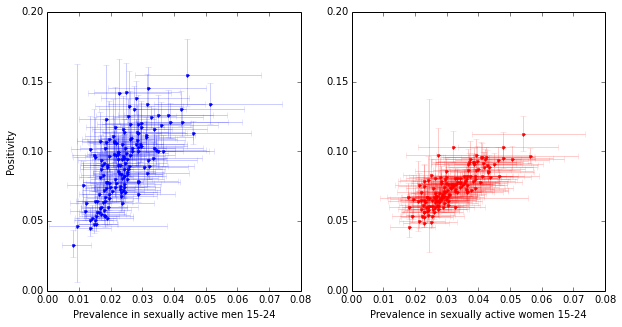

In [6]:
# Figure 2

fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# positivity
pos_m_la = diag_sample_m/test_sample_m
pos_f_la = diag_sample_f/test_sample_f

# add to plot
plt_ppc(ax1, prev_m_la, pos_m_la, 0, 95, 'b', alpha=0.2)
ax1.plot(percentile(prev_m_la, 50, 0), percentile(pos_m_la, 50, 0), '.b')
plt_ppc(ax2, prev_f_la, pos_f_la, 0, 95, 'r', alpha=0.2)
ax2.plot(percentile(prev_f_la, 50, 0), percentile(pos_f_la, 50, 0), '.r')

ax1.set_xlim([0,0.08]); ax1.set_ylim([0,0.2])
ax1.set_xlabel('Prevalence in sexually active men 15-24')
ax1.set_ylabel('Positivity')
#ax1.set_title('Sexually active men 15-24')
ax2.set_xlim([0,0.08]); ax2.set_ylim([0,0.2])
ax2.set_xlabel('Prevalence in sexually active women 15-24')
#ax2.set_ylabel('Positivity')
#ax2.set_title('Sexually active women 15-24')


Although there is a positive correlation between prevalence and positivity, positivity is consistently higher because the sample of individuals tested is enriched with infected individuals seeking treatment because of symptoms. There are also a large number of possible pairs of local authorities in which the authority with the lower positivity has the higher prevalence.

The confidence intervals on the positivity and prevalence estimates are wide, but much of this uncertainty stems from weak information on the model's natural history parameters. To understand the correlation better, we estimate Spearman's rho separately for each multivariate sample of model parameters, testing and diagnosis rates:

In [7]:
from scipy import stats

# examine the Spearman correlation by sample
spearman = empty([shape(pos_m_la)[0],2])
p_val = empty([shape(pos_m_la)[0],2])

for i in xrange(shape(pos_m_la)[0]):
    spearman[i,0] = stats.spearmanr(prev_m_la[i], pos_m_la[i])[0]
    spearman[i,1] = stats.spearmanr(prev_f_la[i], pos_m_la[i])[0]
    p_val[i,0] = stats.spearmanr(prev_m_la[i], pos_m_la[i])[1]
    p_val[i,1] = stats.spearmanr(prev_f_la[i], pos_m_la[i])[1]
    
# find the (0, 2.5, 25, 50, 97.5, 100)th centiles of the p-values, 
# for men (left) and women (right)
percentile(p_val, [0,2.5,25,50,75,97.5,100], axis=0)


[array([  1.04755350e-173,   2.06354452e-014]),
 array([  1.29156539e-65,   4.90912283e-10]),
 array([  2.89673284e-29,   4.20692935e-08]),
 array([  5.76022005e-21,   3.17066706e-07]),
 array([  5.88944724e-16,   2.00062271e-06]),
 array([  1.49526226e-10,   3.80620189e-05]),
 array([  9.51334495e-07,   2.51852969e-03])]

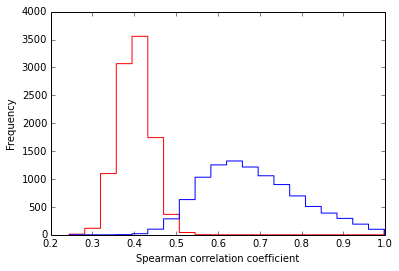

In [8]:
# Figure 3

# Set the default color cycle
import matplotlib as mpl
mpl.rcParams['axes.color_cycle'] = ['b','r']

# histogram of the Spearman correlation values
h=plt.hist(spearman, 20, histtype='step')
plt.xlabel('Spearman correlation coefficient')
plt.ylabel('Frequency')

For the samples drawn, the correlation between prevalence and positivity (measured by Spearman's $\rho$) was always positive and statistically significant ($p<0.05$). However, the correlations - especially for women - were sometimes weak (see histograms).

Next, we examine the relationship between local prevalence and observed diagnoses per capita (without allowing for the fact that not all 15-24-year-olds have become sexually active).

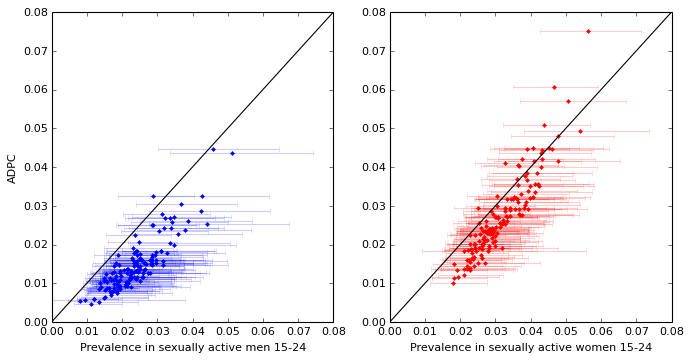

In [89]:
# prevalence vs diagnosis rate

fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.errorbar(
    percentile(prev_m_la, 50, 0), 
    alldata['positives.male.total']/(alldata['population.male.15-19'] + alldata['population.male.20-24']),
    xerr=squeeze(
        array([[percentile(prev_m_la,50, 0) - percentile(prev_m_la, 2.5, 0)], 
            [percentile(prev_m_la, 97.5, 0) - percentile(prev_m_la,50, 0)]])),
    linestyle='None', color='b', alpha=0.2)
ax1.plot(
    percentile(prev_m_la, 50, 0), 
    alldata['positives.male.total']/(alldata['population.male.15-19'] + alldata['population.male.20-24']),
    '.b')
ax2.errorbar(
    percentile(prev_f_la, 50, 0), 
    alldata['positives.female.total']/(alldata['population.female.15-19'] + alldata['population.female.20-24']),
    xerr=squeeze(
        array([[percentile(prev_f_la,50, 0) - percentile(prev_f_la, 2.5, 0)], 
            [percentile(prev_f_la, 97.5, 0) - percentile(prev_f_la,50, 0)]])),
    linestyle='None', color='r', alpha=0.2)
ax2.plot(
    percentile(prev_f_la, 50, 0), 
    alldata['positives.female.total']/(alldata['population.female.15-19'] + alldata['population.female.20-24']),
    '.r')

ax1.set_xlim([0,0.08]); ax1.set_ylim([0,0.08])
ax1.set_xlabel('Prevalence in sexually active men 15-24')
ax1.set_ylabel('ADPC')
#ax1.set_title('Sexually active men 15-24')
ax2.set_xlim([0,0.08]); ax2.set_ylim([0,0.08])
ax2.set_xlabel('Prevalence in sexually active women 15-24')
#ax2.set_ylabel('Positivity')
#ax2.set_title('Sexually active women 15-24')

ax1.plot([0,1],[0,1], 'k')
ax2.plot([0,1],[0,1], 'k')

Incorporating an estimate for the proportion of each age/sex group who are sexually active, the picture is similar: prevalence is again correlated with, but not equal to, diagnosis rate.

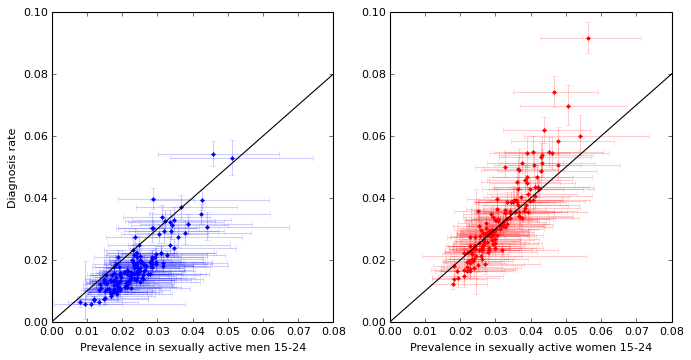

In [93]:
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# add to plot
plt_ppc(ax1, prev_m_la, diag_sample_m, 0, 95, 'b', alpha=0.2)
ax1.plot(percentile(prev_m_la, 50, 0), percentile(diag_sample_m, 50, 0), '.b')
plt_ppc(ax2, prev_f_la, diag_sample_f, 0, 95, 'r', alpha=0.2)
ax2.plot(percentile(prev_f_la, 50, 0), percentile(diag_sample_f, 50, 0), '.r')

ax1.set_xlim([0,0.08]); ax1.set_ylim([0,0.1])
ax1.set_xlabel('Prevalence in sexually active men 15-24')
ax1.set_ylabel('Diagnosis rate')
#ax1.set_title('Sexually active men 15-24')
ax2.set_xlim([0,0.08]); ax2.set_ylim([0,0.1])
ax2.set_xlabel('Prevalence in sexually active women 15-24')
#ax2.set_ylabel('Positivity')
#ax2.set_title('Sexually active women 15-24')

ax1.plot([0,1],[0,1], 'k')
ax2.plot([0,1],[0,1], 'k')

As a consistency check, we calculate weighted averages of the prevalence estimates by LA, and compare these to estimates made from the aggregated national numbers of tests and diagnoses.

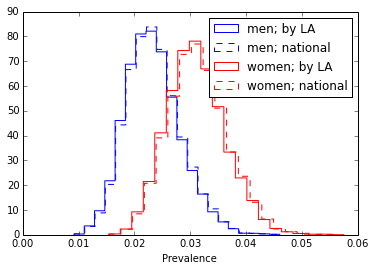

In [9]:
# Figure 4

pop_active_m = empty([n_sample,len(alldata.index)])
pop_active_f = empty([n_sample,len(alldata.index)])

for i in xrange(len(alldata.index)):
    pop_active_m[:,i] = rs.binomial(alldata['population.male.15-19'][i] \
                                    + alldata['population.male.20-24'][i], 
                        p_active_m_16_24, size=n_sample)
    pop_active_f[:,i] = rs.binomial(alldata['population.female.15-19'][i] \
                                    + alldata['population.female.20-24'][i], 
                        p_active_f_16_24, size=n_sample)
    
# testing and diagnosis rates sampled as in england.ipynb
test_rate_m_15_24 = rs.gamma(566908, 1, size=n_sample)/pop_active_m_15_24
diag_rate_m_15_24 = rs.gamma(48387, 1, size=n_sample)/pop_active_m_15_24
test_rate_f_15_24 = rs.gamma(1205896, 1, size=n_sample)/pop_active_f_15_24
diag_rate_f_15_24 = rs.gamma(88101, 1, size=n_sample)/pop_active_f_15_24

inc_m = empty(n_sample); scr_m = empty(n_sample); prev_m = empty(n_sample); 
inc_f = empty(n_sample); scr_f = empty(n_sample); prev_f = empty(n_sample); 

for j in xrange(n_sample):
    # local screening and incidence, given local testing and diagnoses
    [inc_m[j], scr_m[j]] = fsolve(lambda x: test_diag_fun(concatenate([
                    x, array([
                            1-p_asymp_m[j], # proportion of incident infections which are symptomatic
                            sc_m[j], # rate of self-clear 
                            att_symp[j],
                            p_true_pos_m[j], 
                            p_false_pos_m[j]
                        ])])) - array([test_rate_m_15_24[j],diag_rate_m_15_24[j]]), [0.09, 0.25])
    # local prevalence, calculated from local screening and incidence
    prev_m[j] = dyn_fun(
        inc_m[j]*p_asymp_m[j], 
        sc_m[j] + scr_m[j]*p_true_pos_m[j], 
        inc_m[j]*(1-p_asymp_m[j]), 
        scr_m[j]*p_true_pos_m[j] + att_symp[j]*p_true_pos_m[j]
    )
    # local screening and incidence, given local testing and diagnoses
    [inc_f[j], scr_f[j]] = fsolve(lambda x: test_diag_fun(concatenate([
                    x, array([
                            1-p_asymp_f[j], # proportion of incident infections which are symptomatic
                            sc_f[j], # rate of self-clear 
                            att_symp[j],
                            p_true_pos_f[j], 
                            p_false_pos_f[j]
                        ])])) - array([test_rate_f_15_24[j],diag_rate_f_15_24[j]]), [0.09, 0.25])
    # local prevalence, calculated from local screening and incidence
    prev_f[j] = dyn_fun(
        inc_f[j]*p_asymp_f[j], 
        sc_f[j] + scr_f[j]*p_true_pos_f[j], 
        inc_f[j]*(1-p_asymp_f[j]), 
        sc_f[j] + scr_f[j]*p_true_pos_f[j] + att_symp[j]*p_true_pos_f[j]
    )

hm_las=plt.hist(
    sum(prev_m_la*pop_active_m, axis=1)/sum(pop_active_m, axis=1), 
    20, histtype='step', normed='true',
    label = 'men; by LA')
hm_total=plt.hist(prev_m, 20, linestyle='dashed', histtype='step', normed='true', color='b',
    label = 'men; national')
hf_las=plt.hist(
    sum(prev_f_la*pop_active_f, axis=1)/sum(pop_active_f, axis=1), 
    20, histtype='step', color='r', normed='true',
    label = 'women; by LA')
hf_total=plt.hist(prev_f, 20, linestyle='dashed', histtype='step', normed='true', color='r',
    label = 'women; national')

plt.xlabel('Prevalence')
plt.legend()

The sampled prevalence distributions are very close, giving confidence in our method.

## Local differences in prevalence

We now use our samples to compare prevalence by local authority.

In [10]:
shape(prev_m_la)

(10000, 151)

Lowest prevalence in men (median sample): 0.00819755429809
Highest prevalence in men (median sample): 0.0513318116948
Lowest prevalence in women (median sample): 0.0178619507471
Highest prevalence in women (median sample): 0.0561422126184


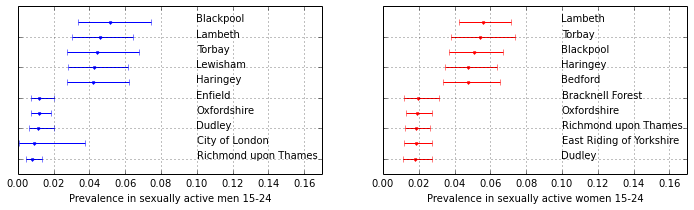

In [11]:
# Figure 5

fig = plt.figure(figsize = (12,3))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

order_m = argsort(percentile(prev_m_la,50,axis=0)) # order by prevalence in men
# Comment-out the next line to plot all LAs. You will also need to adjust axis sizes.
order_m = order_m[append(range(0,5),range(146,151))] 
ax1.errorbar(
    y = range(len(order_m)), 
    x = (percentile(prev_m_la,50,axis=0))[order_m], 
    xerr=array([percentile(prev_m_la[:,order_m],50,axis=0) - percentile(prev_m_la[:,order_m],2.5,axis=0),
            percentile(prev_m_la[:,order_m],97.5,axis=0) - percentile(prev_m_la[:,order_m],50,axis=0)]
            ), 
    fmt='.')

ax1.set_ylim(-1, len(order_m)); ax1.set_xlim(0, 0.17)
ax1.set_xlabel('Prevalence in sexually active men 15-24')
ax1.grid(True)
ax1.set_yticklabels([])

print 'Lowest prevalence in men (median sample):', (percentile(prev_m_la,50,axis=0))[order_m[0]]
print 'Highest prevalence in men (median sample):', (percentile(prev_m_la,50,axis=0))[order_m[-1]]

order_f = argsort(percentile(prev_f_la,50,axis=0)) # order by prevalence in women
# Comment-out the next line to plot all LAs. You will also need to adjust axis sizes.
order_f = order_f[append(range(0,5),range(146,151))] 
ax2.errorbar(
    y = range(len(order_f)), 
    x = (percentile(prev_f_la,50,axis=0))[order_f], 
    xerr=array([percentile(prev_f_la[:,order_f],50,axis=0) - percentile(prev_f_la[:,order_f],2.5,axis=0),
            percentile(prev_f_la[:,order_f],97.5,axis=0) - percentile(prev_f_la[:,order_f],50,axis=0)]
            ), 
    color='r',fmt='.')  

for i in xrange(10):
    ax1.text(0.1, i, alldata.la[order_m[i]])
    ax2.text(0.1, i, alldata.la[order_f[i]])

ax2.set_ylim(-1, len(order_f)); ax2.set_xlim(0, 0.17)
ax2.set_xlabel('Prevalence in sexually active women 15-24')
ax2.grid(True)
ax2.set_yticklabels([])

print 'Lowest prevalence in women (median sample):', (percentile(prev_f_la,50,axis=0))[order_f[0]]
print 'Highest prevalence in women (median sample):', (percentile(prev_f_la,50,axis=0))[order_f[-1]]


In general, the 95% credible intervals for the highest and lowest LAs do not overlap at all, or only slightly. However there is a large group of over 100 LAs with intermediate prevalence, each with a confidence interval overlapping with all the others in the group. (A plot showing all LAs can be obtained by commenting-out the lines indicated above.) Although there are local differences in prevalence, they are generally small compared with the uncertainty in our estimates. Only in the most extreme cases can differences be clearly resolved. However, the rank order of LAs is robust: we examine consistency in rank order below.

We also plot inferred prevalence against deprivation (rank of average score from the English Indices of Deprivation 2010):

no Isles of Scilly 00HF E06000053


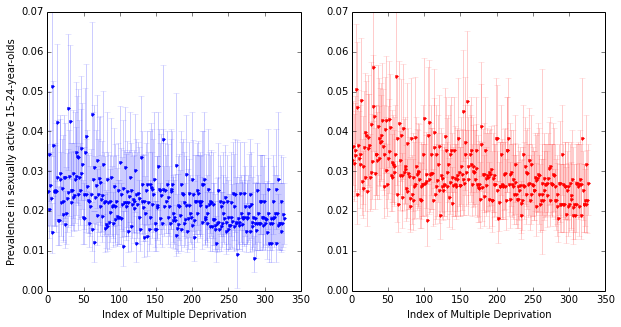

In [12]:
# Figure 6

# lookup table for local authority coding in NCSP vs deprivation data
# Contains National Statistics data © Crown copyright and database right 2016
district_key = pd.read_csv('LAD12_CTY12_EN_LU.csv')

# indices of deprivation downloaded from 
# https://www.gov.uk/government/statistics/english-indices-of-deprivation-2010 1 December 2010
# Contains public sector information licensed under the Open Government Licence v3.0; 
# http://www.nationalarchives.gov.uk/doc/open-government-licence/version/3/
code_key = pd.read_csv('code_equivalents.csv') # downloaded from https://data.gov.uk/dataset/local-authority-districts-uk-2012-names-and-codes 4 January 2016
deprivation = pd.read_csv('deprivation_indices_2010.csv') 

fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

quantiles_m = percentile(prev_m_la, [50,2.5,97.5], 0)
quantiles_f = percentile(prev_f_la, [50,2.5,97.5], 0)

for i in deprivation.index:
    
    old_code = deprivation[u'LA CODE'][i]
    new_code = code_key['Current code'][code_key['Former code'] == old_code].tolist()[0]
    
    # special case for Northumberland, because a new code was allocated when boundaries changed:
    if new_code == 'E06000048': # Northumberland
        new_code = 'E06000057'
    
    if new_code in alldata.la_code.tolist(): # if LA can be found in NCSP data using new code
        ax1.plot(deprivation[u'Rank of Average Score'][i],
                quantiles_m[0][where(alldata.la_code == new_code)],
                '.b')
        ax1.errorbar(deprivation[u'Rank of Average Score'][i],
                quantiles_m[0][where(alldata.la_code == new_code)],
                yerr = array([(quantiles_m[0]-quantiles_m[1])[where(alldata.la_code == new_code)],
                             (quantiles_m[2]-quantiles_m[0])[where(alldata.la_code == new_code)]]),
                color='b', alpha=0.2)
        ax2.plot(deprivation[u'Rank of Average Score'][i],
                quantiles_f[0][where(alldata.la_code == new_code)],
                '.r')
        ax2.errorbar(deprivation[u'Rank of Average Score'][i],
                quantiles_f[0][where(alldata.la_code == new_code)],
                yerr = array([(quantiles_f[0]-quantiles_f[1])[where(alldata.la_code == new_code)],
                             (quantiles_f[2]-quantiles_f[0])[where(alldata.la_code == new_code)]]),
                color='r', alpha=0.2)
    elif old_code in district_key['LAD12CDO'].tolist(): # if LA can be found in list of districts
        new_code = district_key['CTY12CD'][district_key['LAD12CDO']==old_code].tolist()[0]
        # special case for Gateshead, because a new code was allocated when boundaries changed:
        if old_code == '00CH':
            new_code = 'E08000037'
        ax1.plot(deprivation[u'Rank of Average Score'][i],
            quantiles_m[0][where(alldata.la_code == new_code)],
            '.b') 
        ax1.errorbar(deprivation[u'Rank of Average Score'][i],
                quantiles_m[0][where(alldata.la_code == new_code)],
                yerr = array([(quantiles_m[0]-quantiles_m[1])[where(alldata.la_code == new_code)],
                             (quantiles_m[2]-quantiles_m[0])[where(alldata.la_code == new_code)]]),
                color='b', alpha=0.2)
        ax2.plot(deprivation[u'Rank of Average Score'][i],
            quantiles_f[0][where(alldata.la_code == new_code)],
            '.r')            
        ax2.errorbar(deprivation[u'Rank of Average Score'][i],
                quantiles_f[0][where(alldata.la_code == new_code)],
                yerr = array([(quantiles_f[0]-quantiles_f[1])[where(alldata.la_code == new_code)],
                             (quantiles_f[2]-quantiles_f[0])[where(alldata.la_code == new_code)]]),
                color='r', alpha=0.2)
    else: 
        # Scilly Isles not plotted because excluded due to low numbers
        print 'no', deprivation[u'LA NAME'][i], old_code, new_code 
    
ax1.set_xlim([0,350]); ax1.set_ylim([0,0.07])
ax1.set_xlabel('Index of Multiple Deprivation')
ax1.set_ylabel('Prevalence in sexually active 15-24-year-olds')
#ax1.set_title('Sexually active men 15-24 years')
ax2.set_xlim([0,350]); ax2.set_ylim([0,0.07])
ax2.set_xlabel('Index of Multiple Deprivation')
#ax2.set_ylabel('Prevalence')
#ax2.set_title('Sexually active women 15-24 years')


The pattern shown, of higher prevalence in more deprived areas, agrees with primary analysis of Natsal-3 (Sonnenberg _et al._, 2013) which identified index of multiple deprivation quintile as a risk factor for chlamydia infection.

We can also show local prevalence on a map:

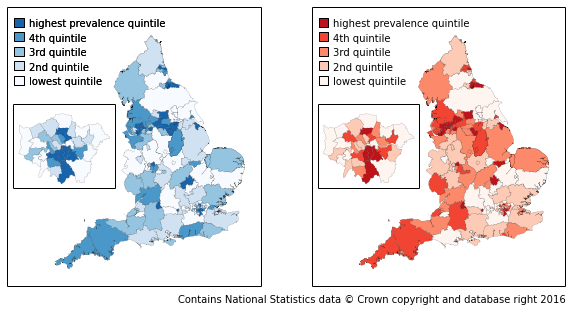

In [23]:
# Figure 7

import shapefile
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

sf = shapefile.Reader("County_and_unitary_authorities_E+W_2013_Boundaries_Generalised_Clipped/CTYUA_DEC_2013_EW_BGC")
recs    = sf.records()
shapes  = sf.shapes()

blues = plt.get_cmap('Blues')  # this returns a colormap
reds = plt.get_cmap('Reds')  # this returns a colormap

key_ys = array([5.2, 5.6, 6, 6.4, 6.8])*10**5 # y-co-ordinates for key
key_labels = ['lowest quintile','2nd quintile','3rd quintile','4th quintile','highest prevalence quintile']

fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(121)
ains1 = inset_axes(ax1, width='40%', height='30%', loc=6)
ax2 = fig.add_subplot(122)
ains2 = inset_axes(ax2, width='40%', height='30%', loc=6)

n_quantile = 5 # how many different colours do you want to plot?

def tickpar(ax):
    ax.tick_params(
        axis='both', # changes apply to 
        which='both', # both major and minor ticks are affected
        bottom='off', # ticks along the bottom edge are off
        top='off', # ticks along the top edge are off
        left='off',      
        right='off',         
        labelbottom='off',
        labelleft='off') # labels along the left edge are off
    
#######################
# plot prevalence in men
#######################

cNorm  = plt.Normalize(vmin=0, vmax=n_quantile)
scalarMap = plt.cm.ScalarMappable(norm=cNorm, cmap=blues)
colors = argsort(percentile(prev_m_la,50,0))
ranks = argsort(colors)
#patches = []

for nshp in alldata.index:
    
   
    # code for this LA
    thiscode = alldata.la_code[nshp]
    # index to find the right shape file for this la:
    shpin = where( map(lambda x: thiscode == x, [recs[i][0] for i in range(len(recs))]) ) 
    shpin = int(shpin[0])
    
    ptchs   = []
    ptchs_l   = [] # for london
    pts     = array(shapes[shpin].points)
    prt     = shapes[shpin].parts
    par     = list(prt) + [pts.shape[0]]
    
    colorVal = scalarMap.to_rgba(n_quantile*ranks[nshp]/151)
    
    for pij in xrange(len(prt)):
        ptchs.append(Polygon(pts[par[pij]:par[pij+1]]))
        
        p = PatchCollection(ptchs, facecolor=colorVal, edgecolor='k', linewidth=0.1)
        p.set_clim([0,151])
        ax1.add_collection(p)
        
        if alldata.gor[nshp] == 'london':
            p = PatchCollection(ptchs, facecolor=colorVal, edgecolor='k', linewidth=0.1)
            ains1.add_collection(p)

for i in xrange(5):
    ax1.add_patch(patches.Rectangle((0.2*10**5, key_ys[i]), 0.25*10**5, 0.25*10**5, fc=blues(0.2*i)))
    ax1.text(0.6*10**5, key_ys[i], key_labels[i])

ax1.text(0.6*10**5, 6.8*10**5, 'highest prevalence quintile')
ax1.text(0.6*10**5, 6.4*10**5, '4th quintile')
ax1.text(0.6*10**5, 6*10**5, '3rd quintile')
ax1.text(0.6*10**5, 5.6*10**5, '2nd quintile')
ax1.text(0.6*10**5, 5.2*10**5, 'lowest quintile')

ax1.set_xlim(0, 0.7*10**6)
ax1.set_ylim(0, 0.7*10**6)
ax1.set_aspect('equal', 'datalim')
tickpar(ax1)
ains1.set_xlim(0.5*10**6, 0.565*10**6)
ains1.set_ylim(1.55*10**5, 2.05*10**5)
ains1.set_aspect('equal', 'datalim')
tickpar(ains1)
p = PatchCollection(ptchs, cmap=blues)
p = PatchCollection(ptchs_l, cmap=blues)

#######################
# plot prevalence in women
#######################

cNorm  = plt.Normalize(vmin=0, vmax=n_quantile)
scalarMap = plt.cm.ScalarMappable(norm=cNorm, cmap=reds)
colors = argsort(percentile(prev_f_la,50,0))
ranks = argsort(colors)
#patches = []

for nshp in alldata.index:
    
    # code for this LA
    thiscode = alldata.la_code[nshp]
    # index to find the right shape file for this la:
    shpin = where( map(lambda x: thiscode == x, [recs[i][0] for i in range(len(recs))]) ) 
    shpin = int(shpin[0])
    
    ptchs   = []
    ptchs_l   = []
    pts     = array(shapes[shpin].points)
    prt     = shapes[shpin].parts
    par     = list(prt) + [pts.shape[0]]
    
    colorVal = scalarMap.to_rgba(n_quantile*ranks[nshp]/151)
    
    for pij in xrange(len(prt)):
        ptchs.append(Polygon(pts[par[pij]:par[pij+1]]))
        
        p = PatchCollection(ptchs, facecolor=colorVal, edgecolor='k', linewidth=0.1)
        p.set_clim([0,151])
        ax2.add_collection(p)

        if alldata.gor[nshp] == 'london':
            p = PatchCollection(ptchs, facecolor=colorVal, edgecolor='k', linewidth=0.1)
            ains2.add_collection(p)

for i in xrange(5):
    ax2.add_patch(patches.Rectangle((0.2*10**5, key_ys[i]), 0.25*10**5, 0.25*10**5, fc=reds(0.2*i)))
    ax2.text(0.6*10**5, key_ys[i], key_labels[i])

ax2.set_xlim(0, 0.7*10**6)
ax2.set_ylim(0, 0.7*10**6)
ax2.set_aspect('equal', 'datalim')
ains2.set_xlim(0.5*10**6, 0.565*10**6)
ains2.set_ylim(1.55*10**5, 2.05*10**5)
ains2.set_aspect('equal', 'datalim')
tickpar(ax2)
tickpar(ains2)
p = PatchCollection(ptchs, cmap=reds)

# Crown Copyright statement required by ONS.
fig.text(0.9,0.1,u'Contains National Statistics data \N{COPYRIGHT SIGN} Crown copyright and database right 2016', ha='right', va='top')
# alternative, if plotting for men only
#fig.text(0.48,0.1,u'Contains National Statistics data \n\N{COPYRIGHT SIGN} Crown copyright and database right 2016', ha='right', va='top')


A proportion of the uncertainty in absolute prevalence values is due to uncertainty in model parameters that do not vary across LAs; to make comparisons of relative prevalence across LAs while controlling for this uncertainty in parameters, we compare the prevalence calculated for each LA, at each sampled set of model parameters.

(0, 0.1)

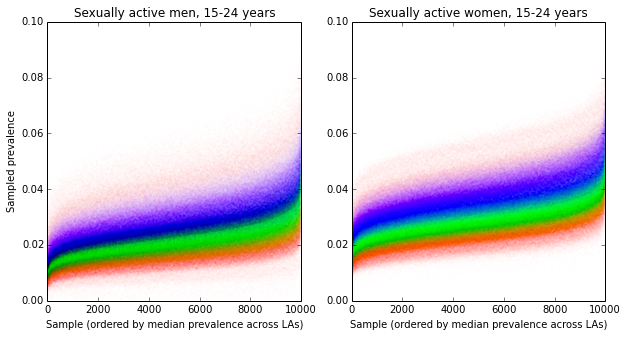

In [24]:
# Figure 8

import matplotlib.colors as colors
import matplotlib.cm as cmx

fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# sort samples
prev_m_la = prev_m_la[argsort(percentile(prev_m_la,50,1)),:]
prev_f_la = prev_f_la[argsort(percentile(prev_f_la,50,1)),:]

rb = plt.get_cmap('gist_rainbow')  # this returns a colormap
ax1.set_color_cycle(rb(array(range(151))/151.))
p1=ax1.plot(
    range(n_sample),
    prev_m_la[:,argsort(percentile(prev_m_la,50,0))], 
    '.', markersize=0.01,alpha=0.5)
ax2.set_color_cycle(rb(array(range(151))/151.))
p2=ax2.plot(
    range(n_sample),
    prev_f_la[:,argsort(percentile(prev_f_la,50,0))], 
    '.', markersize=0.01,alpha=0.5)

ax1.set_xlabel('Sample (ordered by median prevalence across LAs)')
ax1.set_ylabel('Sampled prevalence')
ax1.set_title('Sexually active men, 15-24 years')
ax1.set_ylim([0,0.1])
ax2.set_xlabel('Sample (ordered by median prevalence across LAs)')
ax2.set_title('Sexually active women, 15-24 years')
ax2.set_ylim([0,0.1])

In each panel (left, men; right, women) one dot represents one sampled prevalence in one local authority. Its position on the x-axis corresponds to one set of sampled parameters (Table 2 in the main text) and indicates whether this set generally estimated prevalence to be low, intermediate or high by ordering for the median prevalence across LAs. The position on the y-axis is the sampled prevalence. The colour is unique to each LA, and determined on a colour scale according to that LA’s median sampled prevalence so that low-prevalence LAs are red and high-prevalence are violet. 

The samples for each LA form a band – indicating that rank of prevalence is largely preserved across samples. The fact that the bands overlap shows that there is some swapping of rank order – this is due to uncertainty in the rate of testing and diagnosis. The y-range over which the band moves as it goes from left to right is at least as great as the thickness of the band itself, showing that uncertainty in the model parameters in Table 2 contributes at least as much variation in the final sample as does uncertainty in the testing and diagnosis rates. Improving estimates of natural history and behaviour parameters would improve prevalence estimates.

Another approach to examing the same question is shown below:

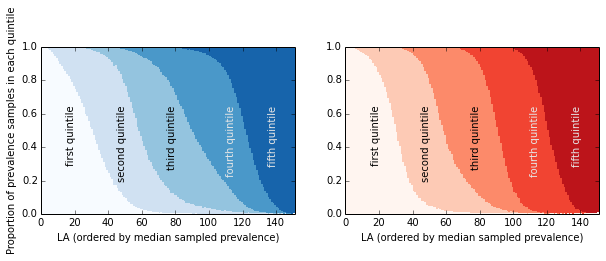

In [25]:
# Figure 9

n_quantiles = 5 # choose how many bands you'd like to plot

fig = plt.figure(figsize = (10,3))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# sort las
prev_m_la_s = prev_m_la[:,argsort(percentile(prev_m_la,50,0))]
prev_f_la_s = prev_f_la[:,argsort(percentile(prev_f_la,50,0))]

# men
blues = plt.get_cmap('Blues')
quantiles = n_quantiles*argsort(prev_m_la_s,axis=1)/151
sizes = [bincount(quantiles[:,i], minlength=n_quantiles) for i in range(151)]
bottoms = zeros(151)
for i in xrange(n_quantiles):
    ax1.bar(range(151), array([sizes[j][i] for j in range(151)])/float(n_sample), 
            1, 
            bottoms, 
            color=blues((0.+i)/n_quantiles), edgecolor='None')
    bottoms = bottoms + array([sizes[j][i] for j in range(151)])/float(n_sample)

# these labels are positioned for quintiles
ax1.annotate('first quintile', [15, 0.6], rotation = 'vertical')
ax1.annotate('second quintile', [45, 0.6], rotation = 'vertical')
ax1.annotate('third quintile', [75, 0.6], rotation = 'vertical')
ax1.annotate('fourth quintile', [110, 0.6], rotation = 'vertical', color='0.9')
ax1.annotate('fifth quintile', [135, 0.6], rotation = 'vertical', color='0.9')

ax1.set_xlim([0,151])
ax1.set_ylim([0,1])
ax1.set_xlabel('LA (ordered by median sampled prevalence)')
ax1.set_ylabel('Proportion of prevalence samples in each quintile')
#ax1.set_title('Sexually active men, 15-24 years')

# how many quintiles are occupied >5% of the time?
#howmany = [sum(sizes[i] >= 0.05*n_sample) for i in range(151)] 
#print {x:howmany.count(x)/151. for x in howmany}

# women
reds = plt.get_cmap('Reds')
quantiles = n_quantiles*argsort(prev_f_la_s,axis=1)/151
sizes = [bincount(quantiles[:,i], minlength=n_quantiles) for i in range(151)]
bottoms = zeros(151)
for i in xrange(n_quantiles):
    ax2.bar(range(151), 
            array([sizes[j][i] for j in range(151)])/float(n_sample), 
            1, 
            bottoms, 
            color=reds((0.+i)/n_quantiles), edgecolor='None')
    bottoms = bottoms + array([sizes[j][i] for j in range(151)])/float(n_sample)

# these labels are positioned for quintiles
ax2.annotate('first quintile', [15, 0.6], rotation = 'vertical')
ax2.annotate('second quintile', [45, 0.6], rotation = 'vertical')
ax2.annotate('third quintile', [75, 0.6], rotation = 'vertical')
ax2.annotate('fourth quintile', [110, 0.6], rotation = 'vertical', color='0.9')
ax2.annotate('fifth quintile', [135, 0.6], rotation = 'vertical', color='0.9')

ax2.set_xlim([0,151])
ax2.set_ylim([0,1])
ax2.set_xlabel('LA (ordered by median sampled prevalence)')
#ax2.set_title('Sexually active women, 15-24 years')

# how many quintiles are occupied >5% of the time?
#howmany = [sum(sizes[i] >= 0.05*n_sample) for i in range(151)] 
#print {x:howmany.count(x)/151. for x in howmany}


This time one column represents one LA, ordered by median sampled prevalence (lowest to highest). Each column is filled according to how many times out of 10000 samples the LA fell into the lowest, second, third, fourth or highest quintile for prevalence. (Adjust the first line of this code block to choose the number of quantiles used.) Samples for the lowest-and highest-prevalence LAs are almost always in the lowest and highest quintiles, respectively, whilst LAs with prevalence estimates in the middle of the range are more likely to be found in two or sometimes three quintiles. There is again a clear order of prevalence which is generally preserved regardless of the particular sampled model parameters.

## Prevalence and incidence

Finally, we plot incidence in each sex against prevalence in the other to examine the effect of infection levels in men on the rate of new infections in women, and vice versa.

In [48]:
#print (alldata.la == 'Brighton and Hove') | (alldata.la == 'Manchester')
print interest
print percentile(prev_m_la[:,interest], 50, 0)[0]
print percentile(inc_f_la[:,interest], 50, 0)[0]

(array([ 83, 137]),)
[ 0.02652801  0.02362203]
[ 0.05876298  0.07464377]


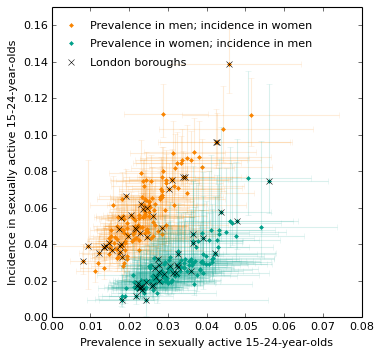

In [57]:
# Figure 10
#plt.rc("savefig", dpi=2300) # for high-resolution version
plt.rc("savefig", dpi=80)

fig = plt.figure(figsize = (5,5), dpi=2300)
ax1 = fig.add_subplot(111)

# add to plot
ax1.plot(percentile(prev_m_la, 50, 0), percentile(inc_f_la, 50, 0), '.', color='#F98400')
ax1.plot(percentile(prev_f_la, 50, 0), percentile(inc_m_la, 50, 0), '.', color='#00A08A')
plt_ppc(ax1, prev_m_la, inc_f_la, 0, 95, '#F98400', alpha=0.15)
plt_ppc(ax1, prev_f_la, inc_m_la, 0, 95, '#00A08A', alpha=0.15)

interest = where((alldata.phec == 'London'))
ax1.plot(percentile(prev_m_la[:,interest], 50, 0)[0], percentile(inc_f_la[:,interest], 50, 0)[0],'xk')
ax1.plot(percentile(prev_f_la[:,interest], 50, 0)[0], percentile(inc_m_la[:,interest], 50, 0)[0],'xk')

ax1.set_xlim([0,0.08]); ax1.set_ylim([0,0.17])

ax1.set_xlabel('Prevalence in sexually active 15-24-year-olds'); 
ax1.set_ylabel('Incidence in sexually active 15-24-year-olds'); 

ax1.plot(0.005, 0.16, '.', c='#F98400')
ax1.text(0.01, 0.16, 'Prevalence in men; incidence in women', va='center')
ax1.plot(0.005, 0.15, '.', c='#00A08A')
ax1.text(0.01, 0.15, 'Prevalence in women; incidence in men', va='center')
ax1.plot(0.005, 0.14, 'x', c='k')
ax1.text(0.01, 0.14, 'London boroughs', va='center')


Orange indicates the relationship between prevalence in men and incidence in women, and green shows the relationship between prevalence in women and incidence in men.

An natural question is why some LAs have higher incidence and prevalence than others. One possibility is that higher screening rates in some areas lower prevalence and incidence. To investigate this, we plot incidence against screening in men and women:

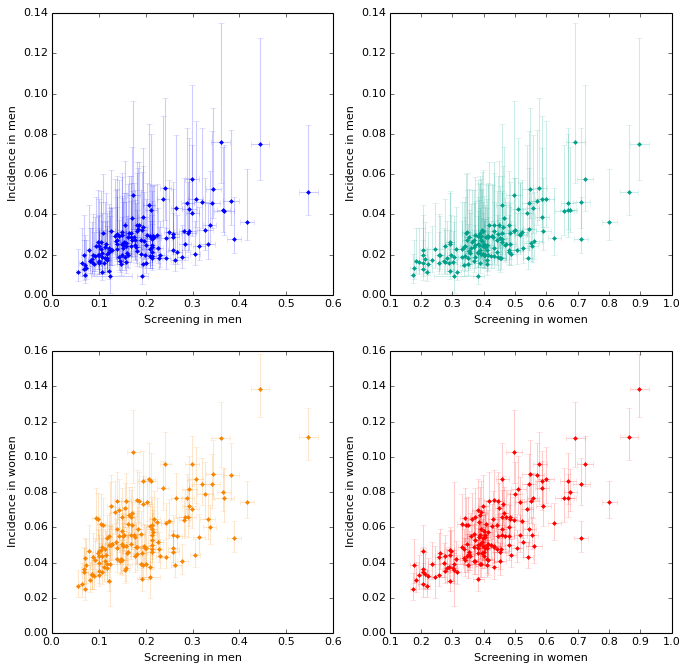

In [17]:
# Figure 11

fig = plt.figure(figsize = (10,10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

plt_ppc(ax1, scr_m_la, inc_m_la, 0, 95, 'b', alpha=0.2)
ax1.plot(percentile(scr_m_la,50,axis=0), percentile(inc_m_la,50,axis=0), '.b')
ax1.set_xlabel('Screening in men'); ax1.set_ylabel('Incidence in men')

plt_ppc(ax2, scr_f_la, inc_m_la, 0, 95, '#00A08A', alpha=0.2)
ax2.plot(percentile(scr_f_la,50,axis=0), percentile(inc_m_la,50,axis=0), '.', c='#00A08A')
ax2.set_xlabel('Screening in women'); ax2.set_ylabel('Incidence in men')

plt_ppc(ax3, scr_m_la, inc_f_la, 0, 95, '#F98400', alpha=0.2)
ax3.plot(percentile(scr_m_la,50,axis=0), percentile(inc_f_la,50,axis=0), '.', c='#F98400')
ax3.set_xlabel('Screening in men'); ax3.set_ylabel('Incidence in women')

plt_ppc(ax4, scr_f_la, inc_f_la, 0, 95, 'r', alpha=0.2)
ax4.plot(percentile(scr_f_la,50,axis=0), percentile(inc_f_la,50,axis=0), '.', c='r')
ax4.set_xlabel('Screening in women'); ax4.set_ylabel('Incidence in women')

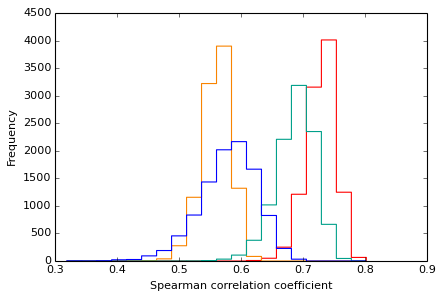

In [18]:
# Figure 12

# examine the Spearman correlation by sample
spearman = empty([n_sample,4])

for i in xrange(shape(pos_m_la)[0]):
    spearman[i,0] = stats.spearmanr(scr_m_la[i], inc_m_la[i])[0]
    spearman[i,1] = stats.spearmanr(scr_f_la[i], inc_m_la[i])[0]
    spearman[i,2] = stats.spearmanr(scr_m_la[i], inc_f_la[i])[0]
    spearman[i,3] = stats.spearmanr(scr_f_la[i], inc_f_la[i])[0]

mpl.rcParams['axes.color_cycle'] = ['b','#00A08A','#F98400','r']
h=plt.hist(spearman, 20, histtype='step', )
plt.xlabel('Spearman correlation coefficient')
plt.ylabel('Frequency')

(Colours correspond to marker colours in the plot above.) In fact, the positive correlations show that areas with more screening tend to have higher incidence.

We also examine the relationship with prevalence:

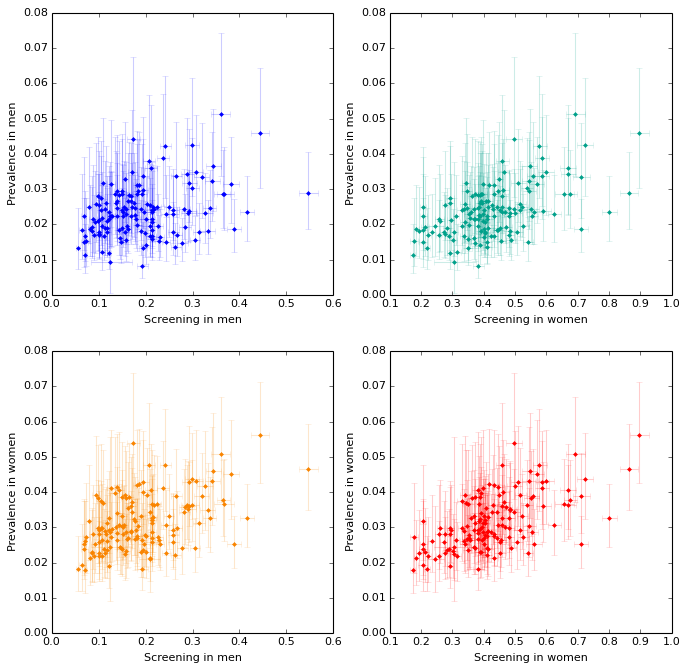

In [19]:
# Figure 13

fig = plt.figure(figsize = (10,10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

plt_ppc(ax1, scr_m_la, prev_m_la, 0, 95, 'b', alpha=0.2)
ax1.plot(percentile(scr_m_la,50,axis=0), percentile(prev_m_la,50,axis=0), '.b')
ax1.set_xlabel('Screening in men'); ax1.set_ylabel('Prevalence in men')

plt_ppc(ax2, scr_f_la, prev_m_la, 0, 95, '#00A08A', alpha=0.2)
ax2.plot(percentile(scr_f_la,50,axis=0), percentile(prev_m_la,50,axis=0), '.', c='#00A08A')
ax2.set_xlabel('Screening in women'); ax2.set_ylabel('Prevalence in men')

plt_ppc(ax3, scr_m_la, prev_f_la, 0, 95, '#F98400', alpha=0.2)
ax3.plot(percentile(scr_m_la,50,axis=0), percentile(prev_f_la,50,axis=0), '.', c='#F98400')
ax3.set_xlabel('Screening in men'); ax3.set_ylabel('Prevalence in women')

plt_ppc(ax4, scr_f_la, prev_f_la, 0, 95, 'r', alpha=0.2)
ax4.plot(percentile(scr_f_la,50,axis=0), percentile(prev_f_la,50,axis=0), '.', c='r')
ax4.set_xlabel('Screening in women'); ax4.set_ylabel('Prevalence in women')

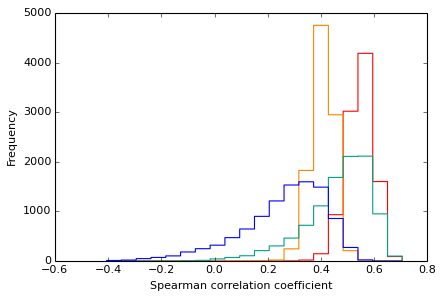

In [20]:
# Figure 14
# examine the Spearman correlation by sample
spearman = empty([n_sample,4])

for i in xrange(shape(pos_m_la)[0]):
    spearman[i,0] = stats.spearmanr(scr_m_la[i], prev_m_la[i])[0]
    spearman[i,1] = stats.spearmanr(scr_f_la[i], prev_m_la[i])[0]
    spearman[i,2] = stats.spearmanr(scr_m_la[i], prev_f_la[i])[0]
    spearman[i,3] = stats.spearmanr(scr_f_la[i], prev_f_la[i])[0]
    
h=plt.hist(spearman, 20, histtype='step', )
plt.xlabel('Spearman correlation coefficient')
plt.ylabel('Frequency')

Prevalence is also generally higher in areas with more screening.

What about the relationship between screening in men vs. women, and screening in men vs. women?

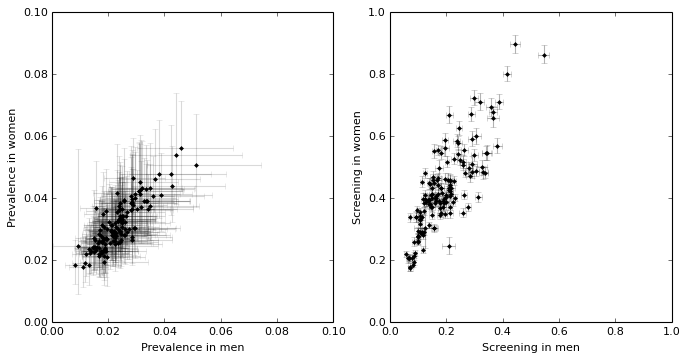

In [21]:
# Figure 15

fig = plt.figure(figsize = (10,5))

ax1 = fig.add_subplot(121)
plt_ppc(ax1, prev_m_la, prev_f_la, 0, 95, 'k', alpha=0.15)
p = ax1.plot(percentile(prev_m_la,50,0), percentile(prev_f_la,50,0), '.', color='k')
ax1.set_xlim(0,0.1)
ax1.set_ylim(0,0.1)
ax1.set_xlabel('Prevalence in men')
ax1.set_ylabel('Prevalence in women')

ax2 = fig.add_subplot(122)
plt_ppc(ax2, scr_m_la, scr_f_la, 0, 95, 'k', alpha=0.3)
p = ax2.plot(percentile(scr_m_la,50,0), percentile(scr_f_la,50,0), '.', color='k')
ax2.set_xlim(0,1)
ax2.set_ylim(0,1)
ax2.set_xlabel('Screening in men')
ax2.set_ylabel('Screening in women')

Prevalence in men and women is positively correlated, because of the incidence-prevalence relationship illustrated above. LAs with more non-symptomatic screening of men also tend to have more screening of women, but all LAs have more screening in women than men.